In [20]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import time
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab 
import scipy.stats as stats

In [21]:
def data_read():
    '''
    This function is to read data from files. Since I only need top 1M, I take only df1
    '''
    df1 = pd.read_csv('data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating',"Date"], usecols = [0,1,2])
    #df2 = pd.read_csv('data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating',"Date"], usecols = [0,1,2])
    #df3 = pd.read_csv('data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
    #df4 = pd.read_csv('data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

    df1['Rating'] = df1['Rating'].astype(float)

    print('Dataset 1 shape: {}'.format(df1.shape))
    print('-Dataset examples-')
    print(df1.iloc[::5000000, :])
    
    df = df1
    #df = df.append(df2)
    #df = df.append(df3)
    #df = df.append(df4)
    print(df)
    return df

In [22]:
def data_purify(df):
    '''
    Next section of codes is to extract the movie id for each of the data.
    top 1M data is selected.
    '''
    start = time.time()
    df = df.reset_index()
    df_nan = pd.DataFrame(pd.isnull(df.Rating))
    df_nan = df_nan[df_nan['Rating'] == True]
    df_nan = df_nan.reset_index()
    #print(df_nan[df_nan["index"] == 0])
    
    movie_np = []
    movie_id = 1

    for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
        # numpy approach
        temp = np.full((i-j-1), movie_id)
        movie_np = np.append(movie_np, temp)
        movie_id += 1

    # Account for last record and corresponding length
    # numpy approach
    last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
    movie_np = np.append(movie_np, last_record)

    end = time.time()
    print("time is ", end-start)
    print('Movie numpy: {}'.format(movie_np))
    print('Length: {}'.format(len(movie_np)))
    
    df = df[pd.notnull(df['Rating'])]
    df['Movie_Id'] = movie_np.astype(int)
    df['Cust_Id'] = df['Cust_Id'].astype(int)
    print('-Dataset examples-')
    print(df.iloc[::5000000, :])
    df = df.iloc[:1000000, :]
    return df

In [23]:
def group_by_time(df):    
    '''
    Next section of code is to sort and group data by time
    '''
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values(by=['Date'])
    group = df.groupby(df['Date'].map(lambda x:x.year))
    for key, con in group:
        print(key, con)
    group_dic = [v for _,v in group]
    return group_dic

In [24]:
def data_preprocessing():
    '''
    
    returns:
        dict: group_dic. This is a dictionary which contains all top 1M data grouped by years
        
        dataframe: df. Data frame of purified data.
        
    This function is used to preprocess the data.
    
    '''
    df = data_read()
    df = data_purify(df)
    group_dic = group_by_time(df)
    
    return group_dic, df

In [25]:
'''
The section of codes consists of 4 functions used in network projections.

'''
def df_to_edges(df):
    temp_df = df[["Cust_Id", "Movie_Id", "Rating"]]
    temp_df["Cust_Id"] = df["Cust_Id"].astype(str)
    temp_df["Movie_Id"] = df["Movie_Id"].astype(int)
    ed = [tuple(row) for _,row in temp_df.iterrows()]
    return ed

def df_to_nodes(df):
    G = nx.Graph()
    G.add_nodes_from(pd.unique(df["Cust_Id"]).astype(str), bipartite=0)
    G.add_nodes_from(pd.unique(df["Movie_Id"]), bipartite=1)
    return G

def proj(B, nodes):
    pred = B.adj
    G = nx.Graph()
    G.graph.update(B.graph)
    G.add_nodes_from((n, B.nodes[n]) for n in nodes)

    n_top = float(len(B) - len(nodes))

    for u in nodes:
        unbrs = set(B[u])
        nbrs2 = {n for nbr in unbrs for n in B[nbr]} - {u}
        for v in nbrs2:
            vnbrs = set(pred[v])
            common = unbrs & vnbrs
            total_dis = 0
            for co in common:
                total_dis += abs(B.edges[u, co]["weight"] - B.edges[v, co]["weight"]) + 1
            weight = total_dis/len(common)
            G.add_edge(u, v, weight=len(common), dist=weight)
    return G

def projection(B):
    top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    bottom_nodes = set(B) - top_nodes
    new_B = proj(B, bottom_nodes)
    return new_B

In [26]:
def get_image(group_dic, index, time_length='year'):
    '''
    params:
        dict: group_dic. This is a dictionary which contains all top 1M data grouped by years
        
        int: index. It is the index for the saving of image.
        
        string: time_length. It is the time_length for the group. Default 'year'
        
    
    returns:
        networkx_object: B. This is a network with 2 edge properties, distance and weight.
        
    
    This function does four things:
        1. Draw and save a graph of the bipartite network for users and movies
        2. Draw and save a graph of the projected network for the movies
        3. Draw and save a graph of the heat map for the weights of the projected movies.
        4. return the projected movie B.
    '''
    
    
    if index >= len(group_dic):
        print("index out of range")
        return False
    ddf = group_dic[index]
    GG = df_to_nodes(ddf)
    GG.add_weighted_edges_from(df_to_edges(ddf))

    
    #Get the bipartite graphs.
    top_nodes = {n for n, d in GG.nodes(data=True) if d["bipartite"] == 0}
    bottom_nodes = set(GG) - top_nodes
    pos = nx.bipartite_layout(GG, top_nodes)
    plt.figure()
    
    nx.draw_networkx_nodes(GG, nodelist=top_nodes, pos=pos, node_shape="d", node_size=5, linewidths=0.05)
    nx.draw_networkx_nodes(GG, nodelist=bottom_nodes, pos=pos, node_shape="o", node_size=5, linewidths=0.05)
    nx.draw_networkx_edges(GG, pos=pos, width=0.1)
    statement = "plot/bi/bipartite graph " + time_length + " for the " + str(index) + " group.png"
    plt.savefig(statement, dpi=300, bbox_inches='tight')
    
    #define a new projection to get the dist and weight
    B = projection(GG)
    edges_list = list(B.edges(data=True))
    #print(edges_list)
    #draw the projection graphs
    pos = nx.random_layout(B)
    #weights = [B[u][v]['weight']/5 for u,v in B.edges]
    plt.figure()
    nx.draw(B, pos=pos, width=0.01)
    statement = "plot/pro/projected graph " +  time_length + " for the " + str(index) + " group.png"
    plt.savefig(statement, dpi=300, bbox_inches='tight')

    #Get new df
    df_new = pd.DataFrame(data=0, columns=df["Movie_Id"].unique(), index=df["Movie_Id"].unique())

    #Draw the heat map of the new df
    for edge in edges_list:
        df_new[edge[0]][edge[1]] = edge[2]["weight"]
        df_new[edge[1]][edge[0]] = edge[2]["weight"]

    plt.figure()
    fig = sns.heatmap(data=df_new,square=True, cmap="RdBu_r", vmin=0, vmax=20000)
    heat_fig = fig.get_figure()
    statement = "plot/heat/heat map of the degrees " +  time_length + " for the " + str(index) + " group.png"
    heat_fig.savefig(statement, dpi=300, bbox_inches='tight')
    
    return B

In [37]:
'''
The section of codes consists of two functions used to analyse the time depending ralationship and draw different plots.

'''

def plot_degree_bar(net):
    num_list = [0]*225
    deg = list(nx.degree(net))
    m = [a[1] for a in deg]
    m = sum(m)/2
    for i, j in deg:
        num_list[i-1] = j/m
    print(len(num_list))
    plt.bar(range(len(num_list)), num_list)

def plot_minus_degree_bar(net1, net2, name):
    num_list1 = [0]*225
    num_list2 = [0]*225
    num_list = [0]*225
    deg1 = list(nx.degree(net1))
    deg2 = list(nx.degree(net2))
    m1 = [a[1] for a in deg1]
    m1 = sum(m1)/2
    for i, j in deg1:
        num_list1[i-1] = j/m1
    m2 = [a[1] for a in deg2]
    m2 = sum(m2)/2
    for i, j in deg2:
        num_list2[i-1] = j/m2
        
    for i in range(len(num_list2)):
        num_list[i] = num_list1[i]-num_list2[i]
    plt.figure()
    plt.bar(range(len(num_list)), num_list)
    statement = "degree_difference_bar_" + name + ".png"
    plt.savefig("")
    return num_list

def qq_plot(num_list, name1, name2):
    num_to_plot = np.array(num_list)
    plt.figure()
    stats.probplot(num_to_plot, dist="norm", plot=pylab)
    plt.savefig("qqplot_" + name1 + "_" + name2 + ".png")

In [38]:
def train_test_split(group_dic, df, random_seed=0):
    '''
    params:
        dict: group_dic. This is a dictionary which contains all top 1M data grouped by years
        
        dataframe df: The total dataset used in training and testing.
        
        int: random_seed. It is the index for getting random states.
        
    The testing data is take as 10% data in total 2005 data. df is the total dataset in the whole procedure.
    
    '''
    df_2005 = group_dic[len(group_dic)-1]
    df_train = df
    train_for_2005 = df_2005.sample(frac=0.9, random_state=random_seed)
    test_for_2005 = df_2005.drop(index = train_for_2005.index)
    train_for_2005 = df_train.drop(index = test_for_2005.index)
    
    return train_for_2005, test_for_2005

In [39]:
'''
This section of codes defines knn and different prediction strategies.
'''

def knn(k, list_for_other, movie, net_71):
    out = []
    
    for i in list_for_other:
        try:
            path = nx.dijkstra_path(net_71,movie,i,weight="dist")
            leng = 0
            for j in range(len(path)-1):
                leng+=net_71.edges[path[j], path[j+1]]["dist"]
            #print(path, leng)
            out.append([i, leng])
            out.sort(key=lambda x:x[1])
            if len(out) > k:
                out = out[:-1]
        except:
            continue
    if len(out) == 0:
        return -1
    else:
        return [x[0] for x in out]

def pred_by_col_knn(k, cus, tar, net_71):
    df_cus = train_for_2005[(train_for_2005['Cust_Id'] == cus)]#############
    df_cus = df_cus[["Rating", "Movie_Id"]]
    df_cus_2 = df_2004[(df_2004['Cust_Id'] == cus)]
    list_11 = df_cus["Movie_Id"].to_list()
    list_22 = df_cus_2['Movie_Id'].to_list()
    #print(cus, list_11, tar)
    out1 = knn(k, list_11, tar, net_71)
    out2 = knn(k, list_22, tar, net_list[-2])
    est = 0
    est2 = 0
    if out1 == -1 and out2 != -1:
        for chosen in out2:
            est += df_cus_2[df_cus_2['Movie_Id'] == chosen]['Rating'].values
        return float(est/len(out2))
    if out2 == -1 and out1 != -1:
        for chosen in out1:
            est += df_cus[df_cus['Movie_Id'] == chosen]['Rating'].values
        return float(est/len(out1))
    if out2 == -1 and out1 == -1:
        return 3
    for chosen in out1:
        est += df_cus[df_cus['Movie_Id'] == chosen]['Rating'].values
    for chosen in out2:
        est2 += df_cus_2[df_cus_2['Movie_Id'] == chosen]['Rating'].values
    #print(est/len(out))
    print(len(out1), len(out2), est, est2)
    return float(0.7*est/len(out1) + 0.3*est2/len(out2))

def pred_by_knn(k, cus, tar, net_71):
    df_cus = train_for_2005[(train_for_2005['Cust_Id'] == cus)]
    df_cus = df_cus[["Rating", "Movie_Id"]]
    list_11 = df_cus["Movie_Id"].to_list()

    #print(cus, list_11, tar)
    out = knn(k, list_11, tar, net_71)
    est = 0
    if out == -1:
        return 3
    
    for chosen in out:
        est += df_cus[df_cus['Movie_Id'] == chosen]['Rating'].values

    #print(est/len(out))
    return float(est/len(out))

def pred_by_conb_knn(k, cus, tar, net_71):
    df_cus = train_for_2005[(train_for_2005['Cust_Id'] == cus)]#############
    df_cus = df_cus[["Rating", "Movie_Id"]]
    df_cus_2 = df_2004[(df_2004['Cust_Id'] == cus)]
    list_11 = df_cus["Movie_Id"].to_list()
    list_22 = df_cus_2['Movie_Id'].to_list()
    #print(cus, list_11, tar)
    out1 = knn(k, list_11, tar, net_71)
    out2 = knn(k, list_22, tar, net_list[-2])
    est = 0
    if out1 == -1 and out2 != -1:
        for chosen in out2:
            est += df_cus_2[df_cus_2['Movie_Id'] == chosen]['Rating'].values
        return float(est/len(out2))
    if out2 == -1 and out1 != -1:
        for chosen in out1:
            est += df_cus[df_cus['Movie_Id'] == chosen]['Rating'].values
        return float(est/len(out1))
    if out2 == -1 and out1 == -1:
        return 3
    for chosen in out1:
        est += df_cus[df_cus['Movie_Id'] == chosen]['Rating'].values
    for chosen in out2:
        est += df_cus_2[df_cus_2['Movie_Id'] == chosen]['Rating'].values
    #print(est/len(out))
    return float(est/(len(out1) + len(out2)))

In [45]:
def knn_pred(net):
    #pre by knn
    test_out_full = []
    cnt = 0
    for i, cont in test_for_2005.iterrows():
        cnt += 1
        if cnt%100==0:
            print(cnt)
        test_out_full.append(pred_by_knn(5, cont["Cust_Id"], cont["Movie_Id"], net))
    return test_out_full

In [46]:
def col_knn_pred(net):
    #pre by col knn
    test_out_col = []
    cnt = 0
    for i, cont in test_for_2005.iterrows():
        cnt += 1
        if cnt%100==0:
            print(cnt)
        test_out_col.append(pred_by_col_knn(5, cont["Cust_Id"], cont["Movie_Id"], net))
    return test_out_col

In [47]:
def conb_knn_pred(net):
    #pre by conbine knn
    test_out_conb = []
    cnt = 0
    for i, cont in test_for_2005.iterrows():
        cnt += 1
        if cnt%100==0:
            print(cnt)
        test_out_conb.append(pred_by_conb_knn(5, cont["Cust_Id"], cont["Movie_Id"], net))
    return test_out_conb

In [48]:
def test_by_mae(test_out, real_rating):
    es = np.array(test_out)
    mae = np.sum(np.absolute(es-real_rating))/len(test_out)
    return mae

Dataset 1 shape: (24058263, 3)
-Dataset examples-
          Cust_Id  Rating        Date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10
          Cust_Id  Rating        Date
0              1:     NaN         NaN
1         1488844     3.0  2005-09-06
2          822109     5.0  2005-05-13
3          885013     4.0  2005-10-19
4           30878     4.0  2005-12-26
...           ...     ...         ...
24058258  2591364     2.0  2005-02-16
24058259  1791000     2.0  2005-02-10
24058260   512536     5.0  2005-07-27
24058261   988963     3.0  2005-12-20
24058262  1704416     3.0  2004-06-02

[24058263 rows x 3 columns]
time is  93.69105696678162
Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764
-Dataset examples-
             index  Cust_Id  Rating        Date  Movie_Id
1                1  1488844     3.0  

<ipython-input-25-6574107872c5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["Cust_Id"] = df["Cust_Id"].astype(str)
<ipython-input-25-6574107872c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["Movie_Id"] = df["Movie_Id"].astype(int)
<ipython-input-26-b4f76ca997dd>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this wa

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

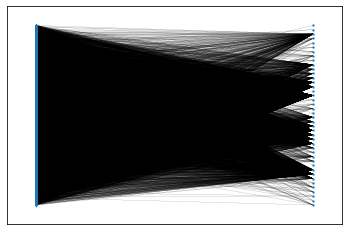

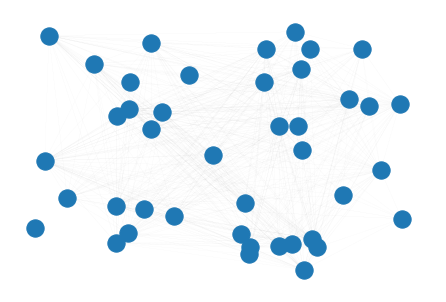

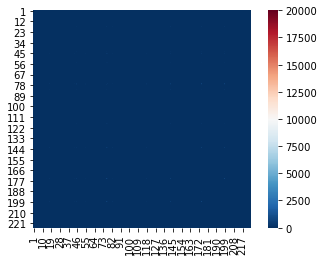

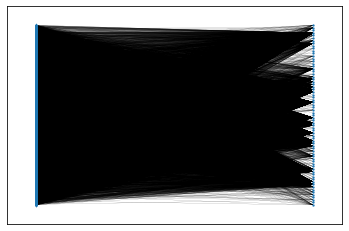

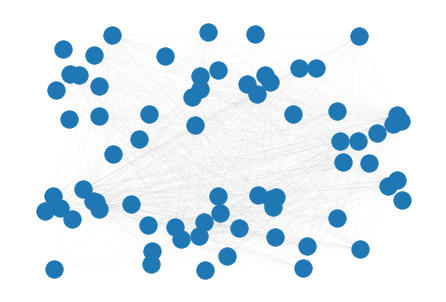

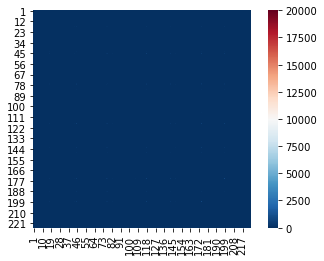

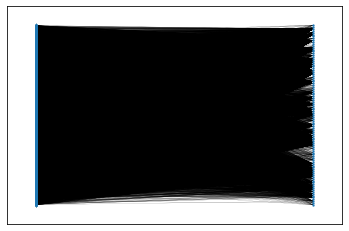

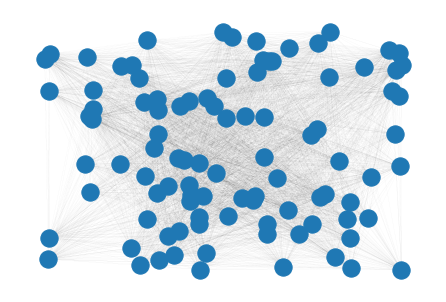

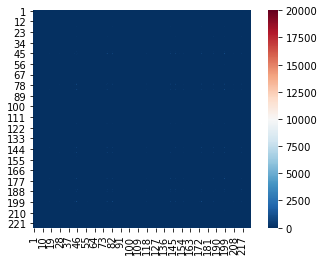

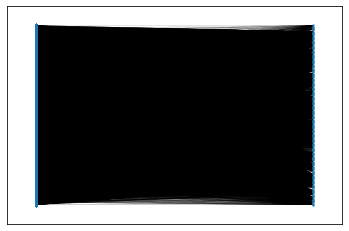

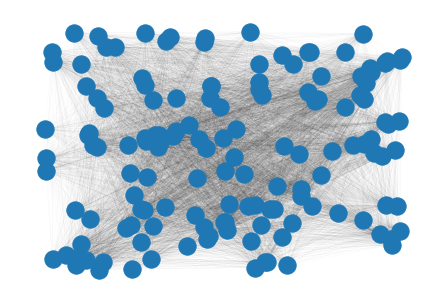

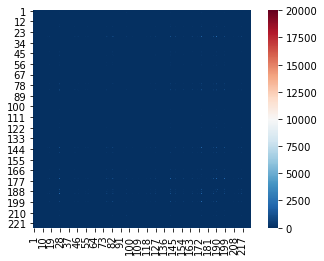

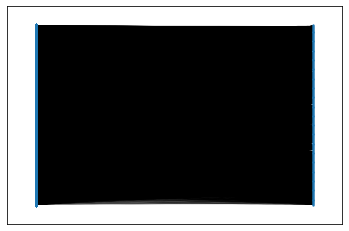

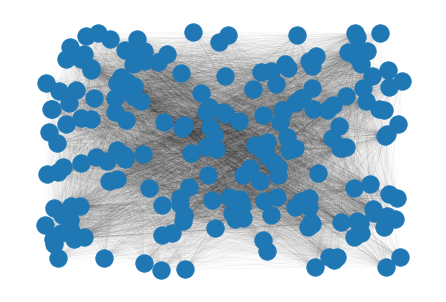

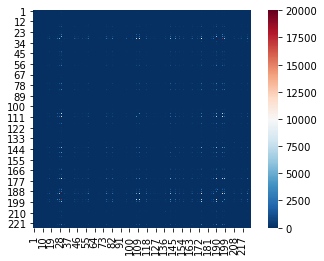

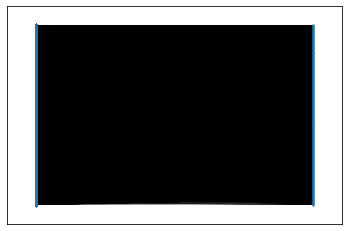

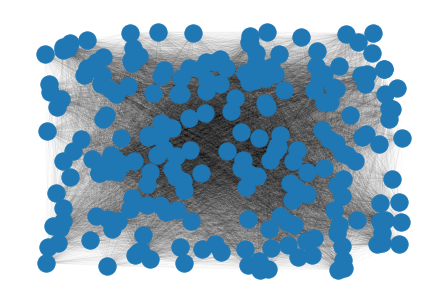

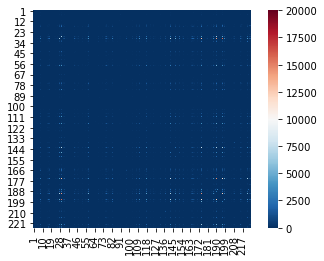

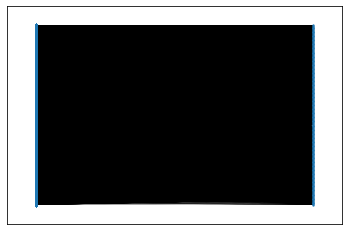

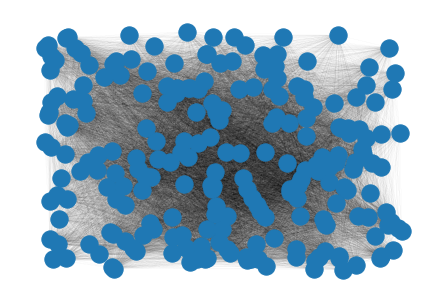

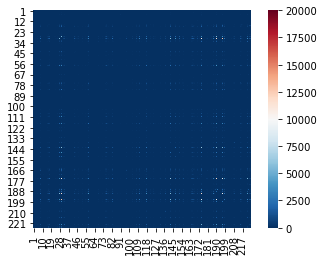

In [49]:
#if __name__ == 'main':
group_dic, df = data_preprocessing()

net_list = []
for i in range(1, len(group_dic)):
    net_list.append(get_image(group_dic, i, "yearly_try"))

#train_for_2005, test_for_2005 = train_test_split(group_dic, df, 0)
train_for_2005, test_for_2005 = train_test_split(group_dic, group_dic[-1], 0)
test_for_2005 = test_for_2005[['Cust_Id', 'Movie_Id' ,"Rating"]]

try_group = [train_for_2005]
net = get_image(try_group, 0, "try_2005")

df_2004 = group_dic[-2][['Cust_Id', 'Movie_Id' ,"Rating"]]

real_rating = test_for_2005["Rating"]

test_out = knn_pred(net)



mae = test_by_mae(test_out, real_rating)
print(mae)